<a href="https://colab.research.google.com/github/ailiskab-hub/ML-projects/blob/main/cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sklearn scipy matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Алгоритмы кластеризации

Задание на сегодня состоит из двух задач. Нужно реализовать алгоритмы k-means и иерархическую кластеризацию.

### 1. K-Means (1 балл)

Реализуйте метод сжатия изображений в формате PNG с помощью кластеризации пикселей.

Общая схема работы метода:

* С помощью алгоритма Ллойда построить по изображению набор из **K** базовых цветов. Базовый цвет – это центроид в пространстве RGB.

* Преобразовать исходное изображение в новое, в котором каждый пиксель заменен на ближайший к нему базовый цвет.

Необходимо, чтобы преобразованное изображение визуально не сильно отличалось от исходного

![image.png](attachment:0bd531ea-f39a-4ac8-a3a1-1b4ad7bcf9d1.png)

Алгоритм минимизирует функцию ошибки (**loss function**) вида

![image.png](attachment:c96ea3bd-fa0a-4b46-abab-958c7a824598.png)

Расстояние между точками евклидово

![image.png](attachment:e80fc4ba-152b-43df-9410-abd48d26adba.png)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.spatial import distance

Для проверки критерия сходимости можно использовать функцию `np.allclose(x, y)`

In [ ]:
np.allclose([[1,2,3], [1,2,3]], [[1,2,3], [1,2,2.95]], atol=0.01)

False

In [ ]:
np.allclose([[1,2,3], [1,2,3]], [[1,2,3], [1,2,2.95]], atol=0.1)

True

#### Загрузка данных

In [ ]:
# Загрузим картинку
img = plt.imread("flower.png")[:,:,:3]

print(img.shape)

(427, 640, 3)


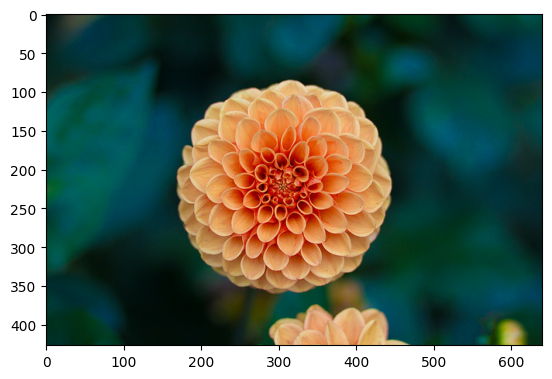

In [ ]:
_ = plt.imshow(img)

In [ ]:
X = img.reshape((-1,3))
print(X.shape)

(273280, 3)


In [ ]:
X

array([[0.00784314, 0.07450981, 0.05098039],
       [0.01176471, 0.07058824, 0.05098039],
       [0.02745098, 0.07843138, 0.05098039],
       ...,
       [0.02745098, 0.18039216, 0.10980392],
       [0.03137255, 0.1764706 , 0.10980392],
       [0.03529412, 0.16862746, 0.10588235]], dtype=float32)

#### Кластеризация



In [ ]:
class KMeans(object):
    def __init__(self, n_clusters, max_iter, seed=0, tol=0.001):
        # число кластеров
        self.n_clusters = n_clusters
        # максимальное число итераций (на случай, если будет долго сходиться)
        self.max_iter = max_iter
        # array-like of shape (n_clusters, n_features) – в эту переменную сохраняются координаты центроидов
        self.centroids = None
        # массив со значениями функции ошибки на каждой итерации
        self.losses = []
        # зерно генератора случайных чисел
        self.seed = seed
        # точность, с которой мы смотрим на изменение положения центроидов
        self.tol = tol

    def distances(self, X):
        '''
        Returns distance from each sample to all centroids
        :param X: array-like of shape (n_samples, n_features)
            Training instances to cluster
        :return dist: array-like of shape (n_samples, n_clusters)
            Matrix of distances
        '''
        n_samples = X.shape[0]
        n_clusters = len(self.centroids)

        dist = np.zeros((n_samples, n_clusters))

        for i in range(n_clusters):
            dist[:, i] = np.linalg.norm(X - self.centroids[i], axis=1)
        return dist

    def loss(self, dist):
        '''
        :param dist: array-like of shape (n_samples, n_clusters)
            Matrix of distances
        :return loss: float
            Value of the loss function
        '''
        n = dist.shape[0]
        sq_dist = np.apply_along_axis(lambda x: x**2, 1, dist)
        minimum = np.min(sq_dist, axis=1)
        loss = np.sum(minimum)/n
        return loss

    def initialize(self, X):
        '''
        Initialize centroids
        :param X: array-like of shape (n_samples, n_features)
            Training instances to cluster

        '''
        np.random.seed(self.seed)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centroids = X[indices]


    def fit_predict(self, X):
        '''
        Implements Lloyd's algorithm
        :param X: array-like of shape (n_samples, n_features)
            Training instances to cluster
        :return labels : ndarray of shape (n_samples,)
            Index of the cluster each sample belongs to.
        '''
        np.random.seed(self.seed)

        self.initialize(X)

        labels = []

        for _ in range(self.max_iter):
            iter_dist = self.distances(X)
            loss_val = self.loss(iter_dist)
            self.losses.append(loss_val)

            labels = np.argmin(np.apply_along_axis(lambda x: x**2, 1, iter_dist), axis=1)

            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])

            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break

            self.centroids = new_centroids

        return labels

Запустим кластеризацию на наших данных

In [ ]:
cls = KMeans(n_clusters=8, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Посмотрим, как убывала функция ошибки

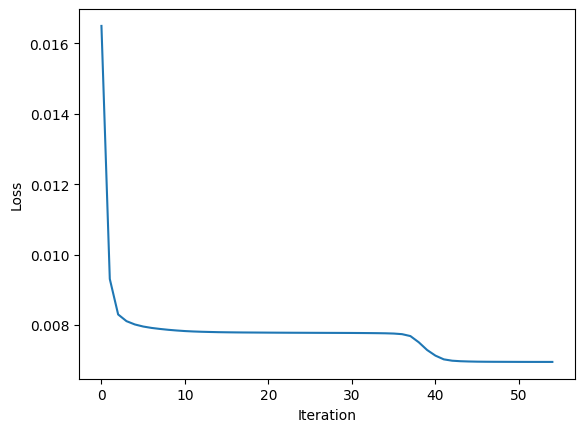

In [ ]:
_ = plt.plot(losses)
_ = plt.xlabel('Iteration')
_ = plt.ylabel('Loss')

Наши центроиды – цвета в пространстве RGB. Можно их нарисовать

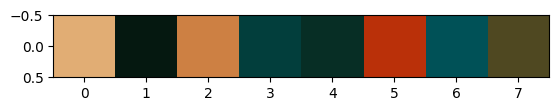

In [ ]:
_ = plt.imshow([centroids])

In [ ]:
centroids

array([[0.88357335, 0.6788931 , 0.4557465 ],
       [0.02195635, 0.09486082, 0.06662621],
       [0.8050544 , 0.50344175, 0.26640815],
       [0.0079911 , 0.24451199, 0.23846288],
       [0.02767102, 0.18372686, 0.14851008],
       [0.73229986, 0.19059576, 0.03724746],
       [0.00270558, 0.3203603 , 0.34243128],
       [0.31326398, 0.28384587, 0.13238186]], dtype=float32)

In [ ]:
y_pred

array([1, 1, 1, ..., 4, 4, 4])

Теперь сделайте из `X` матрицу `Y`, в которой координаты каждой точки заменены на координаты центроида

In [ ]:
Y = np.array(centroids[y_pred])

Посмотрим, что получилось

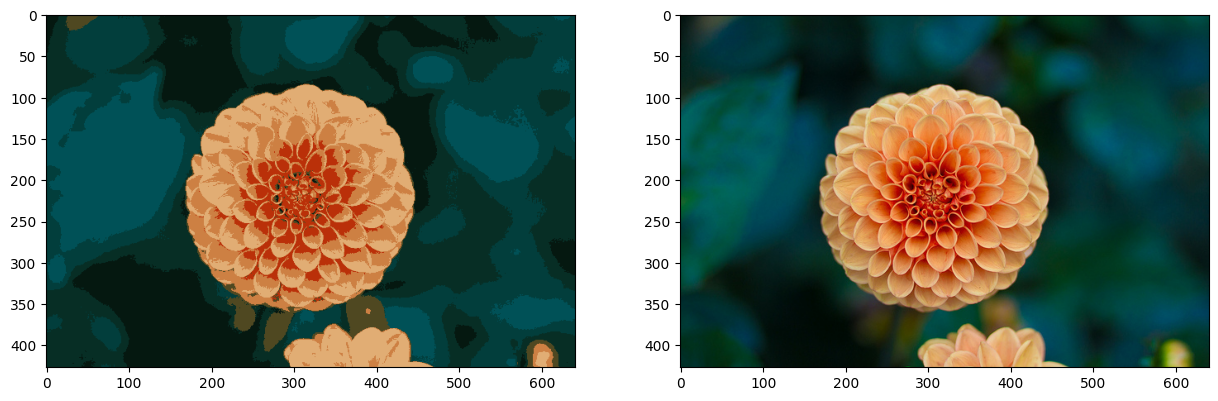

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

Поэкспериментируйте с разным числом кластеров

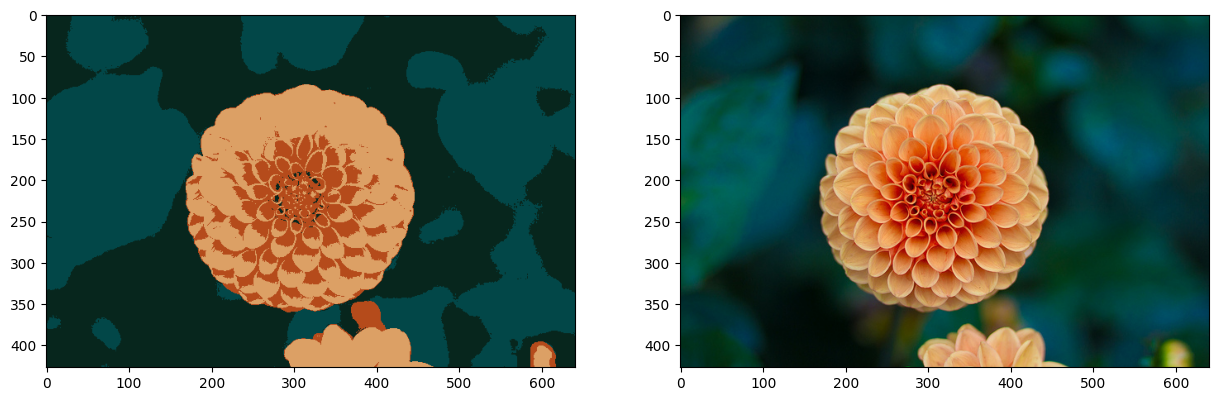

In [ ]:
cls = KMeans(n_clusters=4, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Y = centroids[y_pred, :]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

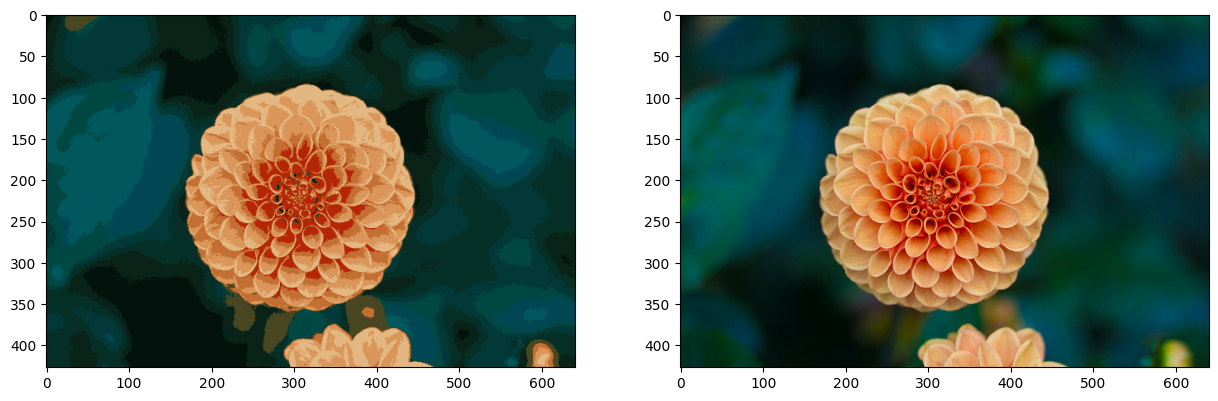

In [ ]:
cls = KMeans(n_clusters=12, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Y = centroids[y_pred, :]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

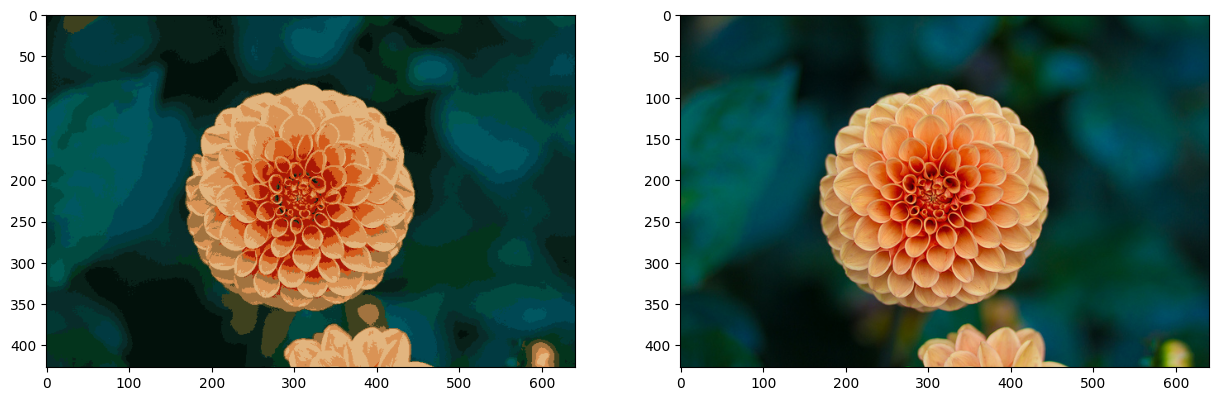

In [ ]:
cls = KMeans(n_clusters=16, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Y = centroids[y_pred, :]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

### 2. Иерархическая кластеризация (1 балл)

---



![image.png](attachment:9e614661-48df-4408-883f-959e7669c6b3.png)

Для вычисления расстояний между кластерами используйте среднее расстояние между входящими в них точками:

![image.png](attachment:3dafa13a-e894-4730-aa6c-a80ddbbd70f7.png)





```
# Выбран кодовый формат
```

#### 2.1. Функция `distance_matrix`, вычисляющая матрицу попарных расстояний между точками.
В качестве метрики мы будем использовать евклидово расстояние,

![image.png](attachment:a96735b3-7330-40aa-8437-fd65967cb228.png)


In [ ]:
def distance_matrix(X):
    '''
    Compute matrix of pair-wise distances between samples
    :param X: array-like of shape (n_samples, n_features)
        Samples
    :return D: array-like of shape (n_samples, n_samples)
        Matrix of pair-wise distances between samples
    '''
    D = distance.squareform(distance.pdist(X))

    return D

#### 2.2. Функция `linkage`.

На вход подается матрица расстояний. На выходе – результат кластеризации в виде матрицы связей. Строки этой матрицы соответствуют операции объединения кластеров. Каждая строка имеет вид

```[C1, C2, dist(C1, C2), N]```

где `C1` и `C2` – номера объединяемых кластеров, `dist(C1, C2)` – расстояние между объединяемыми кластерами, `N` – число точек в новом кластере

Например, кластеризации

![image.png](attachment:21e3a50a-5bc0-4525-ab8d-223403a765fc.png)

соответствует
```
Z = [[ 3.    5.    0.43  2.  ]
     [ 4.    6.    0.55  2.  ]
     [ 2.    7.    0.66  3.  ]
     [ 0.    1.    0.74  2.  ]
     [ 8.    9.    0.82  5.  ]
     [10.   11.    1.12  7.  ]]
```


In [ ]:
def linkage(D1):
    '''
    :param D: array-like of shape (n_samples, n_samples)
            Matrix of pair-wise distances between samples
    :return linkage: Linkage matrix
    '''
    D = D1.copy()
    linkages = []

    for i in range(len(D)):
      D[i][:i+1] = np.inf

    n_samples = D.shape[0]

    clusters = list(range(n_samples))
    lens_dict = {}

    n_unions = len(clusters) - 1
    used_clusters = []

    while n_unions > 0:
        i, j = np.unravel_index(np.argmin(D, axis=None), D.shape)
        merge_indices = (i, j)

        next_cl = len(clusters)# + 1
        clusters.append(next_cl)

        if (i not in lens_dict.keys()) and (j not in lens_dict.keys()) :
            lens_dict[next_cl] = 2
        elif (i in lens_dict.keys()) and (j in lens_dict.keys()) :
            lens_dict[next_cl] = lens_dict[i] + lens_dict[j]
        elif i in lens_dict.keys():
            lens_dict[next_cl] = lens_dict[i] + 1
        elif j in lens_dict.keys():
            lens_dict[next_cl] = lens_dict[j] + 1
        else:
            pass

        N = lens_dict[next_cl]

        used_clusters.extend([i, j])


        n_unions -= 1

        linkages.append([i, j, D[i, j], N])

        d_avg = np.round(np.sum([D1[i], D1[j]], axis=0)/2, 2)

        D = np.hstack((D, d_avg.reshape(-1, 1)))
        D = np.vstack((D, np.full((1, D.shape[1]), np.inf)))

        D1 = np.hstack((D1, d_avg.reshape(-1, 1)))
        D1 = np.vstack((D1, np.append(d_avg.reshape(-1, 1), 0)))

        for cl in used_clusters:
            D[cl] = np.full((1, D.shape[1]), np.inf)
            D[:, cl] = np.full((D.shape[0], 1), np.inf).flatten()

    return linkages

####  Проверка 1

In [ ]:
# Нам дана матрица расстояний
D = np.array([[0.  , 0.74, 0.85, 0.54, 0.83, 0.92, 0.89],
              [0.74, 0.  , 1.59, 1.35, 1.2 , 1.48, 1.55],
              [0.85, 1.59, 0.  , 0.63, 1.13, 0.69, 0.73],
              [0.54, 1.35, 0.63, 0.  , 0.66, 0.43, 0.88],
              [0.83, 1.2 , 1.13, 0.66, 0.  , 0.72, 0.55],
              [0.92, 1.48, 0.69, 0.43, 0.72, 0.  , 0.8 ],
              [0.89, 1.55, 0.73, 0.88, 0.55, 0.8 , 0.  ]])

# кластеризуем
Z = linkage(D)

# и напечатаем что получилось
print(np.array(Z))

[[ 3.    5.    0.43  2.  ]
 [ 4.    6.    0.55  2.  ]
 [ 2.    7.    0.66  3.  ]
 [ 0.    1.    0.74  2.  ]
 [ 8.    9.    0.84  5.  ]
 [10.   11.    1.13  7.  ]]


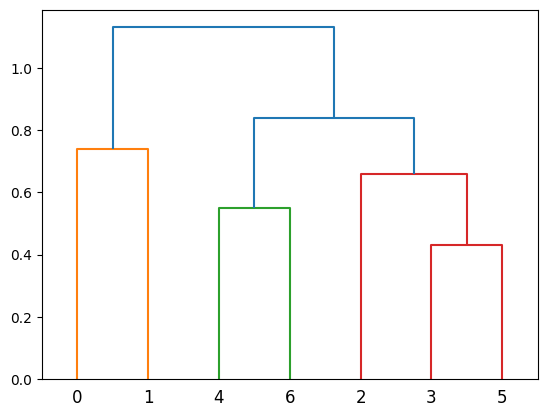

In [ ]:
# для построения дендрограммы воспользуемся функцией из библиотеки scipy
from scipy.cluster.hierarchy import dendrogram

# должна получиться картинка из начала этого раздела
_ = dendrogram(Z)

####  Проверка 2

In [ ]:
D = np.array([
    [0.  , 0.43, 0.93, 0.85, 0.94, 0.7 , 0.95, 0.79, 0.89, 1.34, 0.8 , 0.64, 1.42, 1.37, 0.86, 1.2 , 0.49, 0.19, 1.48, 0.86],
    [0.43, 0.  , 0.66, 0.7 , 1.48, 0.58, 0.7 , 0.55, 0.68, 1.45, 1.31, 0.37, 1.24, 1.69, 0.91, 1.28, 1.04, 0.29, 0.94, 1.05],
    [0.93, 0.66, 0.  , 1.01, 1.42, 0.8 , 0.76, 1.18, 0.21, 1.18, 1.35, 0.82, 0.68, 0.85, 0.75, 1.01, 0.93, 1.03, 0.6 , 0.91],
    [0.85, 0.7 , 1.01, 0.  , 1.02, 0.22, 0.89, 0.91, 0.79, 1.47, 1.04, 1.51, 0.71, 1.63, 0.34, 1.05, 1.24, 0.56, 1.09, 1.25],
    [0.94, 1.48, 1.42, 1.02, 0.  , 1.46, 1.48, 0.95, 1.44, 1.08, 0.3 , 1.29, 1.28, 0.65, 1.  , 0.8 , 0.8 , 0.92, 1.48, 0.65],
    [0.7 , 0.58, 0.8 , 0.22, 1.46, 0.  , 0.77, 1.  , 0.65, 1.25, 1.27, 1.36, 0.81, 1.56, 0.37, 0.98, 1.17, 0.68, 0.88, 1.23],
    [0.95, 0.7 , 0.76, 0.89, 1.48, 0.77, 0.  , 1.41, 1.08, 1.61, 1.65, 0.89, 0.76, 1.32, 0.64, 0.7 , 0.59, 1.07, 0.49, 0.91],
    [0.79, 0.55, 1.18, 0.91, 0.95, 1.  , 1.41, 0.  , 1.05, 0.73, 1.08, 0.7 , 1.49, 1.17, 1.  , 1.34, 1.45, 0.49, 1.06, 1.3 ],
    [0.89, 0.68, 0.21, 0.79, 1.44, 0.65, 1.08, 1.05, 0.  , 0.96, 1.09, 0.94, 0.44, 1.06, 0.9 , 1.47, 1.2 , 0.79, 1.04, 1.39],
    [1.34, 1.45, 1.18, 1.47, 1.08, 1.25, 1.61, 0.73, 0.96, 0.  , 0.96, 1.1 , 1.05, 0.48, 1.36, 1.26, 1.38, 1.38, 1.03, 1.38],
    [0.8 , 1.31, 1.35, 1.04, 0.3 , 1.27, 1.65, 1.08, 1.09, 0.96, 0.  , 1.08, 1.09, 0.79, 1.4 , 1.03, 1.02, 0.78, 1.79, 0.86],
    [0.64, 0.37, 0.82, 1.51, 1.29, 1.36, 0.89, 0.7 , 0.94, 1.1 , 1.08, 0.  , 1.42, 1.2 , 1.61, 1.3 , 0.86, 0.68, 1.04, 0.83],
    [1.42, 1.24, 0.68, 0.71, 1.28, 0.81, 0.76, 1.49, 0.44, 1.05, 1.09, 1.42, 0.  , 0.99, 0.84, 1.2 , 1.21, 1.22, 0.97, 1.58],
    [1.37, 1.69, 0.85, 1.63, 0.65, 1.56, 1.32, 1.17, 1.06, 0.48, 0.79, 1.2 , 0.99, 0.  , 1.13, 0.61, 1.  , 1.6 , 0.81, 0.83],
    [0.86, 0.91, 0.75, 0.34, 1.  , 0.37, 0.64, 1.  , 0.9 , 1.36, 1.4 , 1.61, 0.84, 1.13, 0.  , 0.68, 0.89, 0.86, 0.65, 1.04],
    [1.2 , 1.28, 1.01, 1.05, 0.8 , 0.98, 0.7 , 1.34, 1.47, 1.26, 1.03, 1.3 , 1.2 , 0.61, 0.68, 0.  , 0.92, 1.47, 0.47, 0.42],
    [0.49, 1.04, 0.93, 1.24, 0.8 , 1.17, 0.59, 1.45, 1.2 , 1.38, 1.02, 0.86, 1.21, 1.  , 0.89, 0.92, 0.  , 0.9 , 1.18, 0.49],
    [0.19, 0.29, 1.03, 0.56, 0.92, 0.68, 1.07, 0.49, 0.79, 1.38, 0.78, 0.68, 1.22, 1.6 , 0.86, 1.47, 0.9 , 0.  , 1.56, 1.21],
    [1.48, 0.94, 0.6 , 1.09, 1.48, 0.88, 0.49, 1.06, 1.04, 1.03, 1.79, 1.04, 0.97, 0.81, 0.65, 0.47, 1.18, 1.56, 0.  , 0.84],
    [0.86, 1.05, 0.91, 1.25, 0.65, 1.23, 0.91, 1.3 , 1.39, 1.38, 0.86, 0.83, 1.58, 0.83, 1.04, 0.42, 0.49, 1.21, 0.84, 0.  ]])

Выведите Linkage матрицу и постройте дендрограмму

In [ ]:
Z = linkage(D)

# и напечатаем что получилось
print(np.array(Z))

[[ 0.   17.    0.19  2.  ]
 [ 2.    8.    0.21  2.  ]
 [ 3.    5.    0.22  2.  ]
 [ 4.   10.    0.3   2.  ]
 [ 1.   20.    0.36  3.  ]
 [14.   22.    0.36  3.  ]
 [15.   19.    0.42  2.  ]
 [ 9.   13.    0.48  2.  ]
 [ 6.   18.    0.49  2.  ]
 [11.   24.    0.52  4.  ]
 [12.   21.    0.56  3.  ]
 [ 7.   29.    0.65  5.  ]
 [16.   26.    0.7   3.  ]
 [25.   28.    0.78  5.  ]
 [30.   33.    0.84  8.  ]
 [23.   27.    0.87  4.  ]
 [32.   35.    0.99  7.  ]
 [31.   34.    1.14 13.  ]
 [36.   37.    1.14 20.  ]]


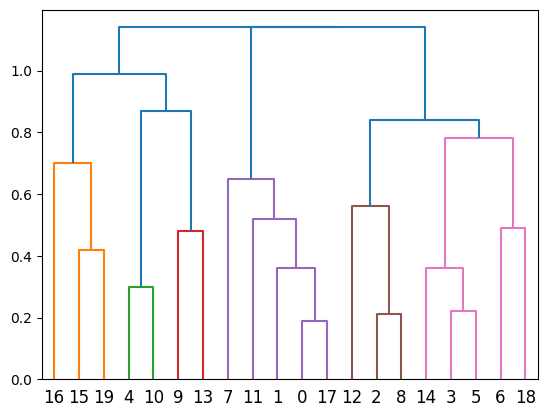

In [ ]:
_ = dendrogram(Z)

#### 2.3. Digits dataset

In [ ]:
from sklearn import datasets

digits = datasets.load_digits().images

In [ ]:
np.random.seed(0)
digits = np.random.permutation(digits)[:20]

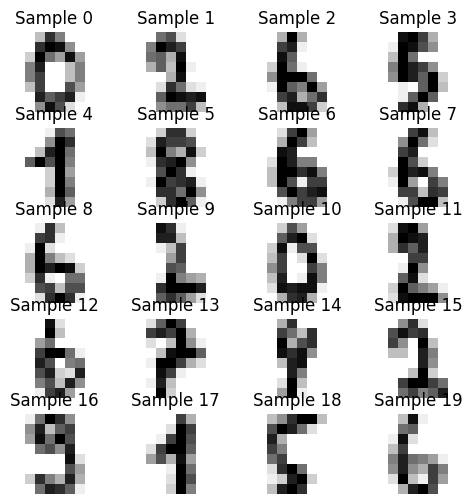

In [ ]:
_, axes = plt.subplots(nrows=5, ncols=4, figsize=(6, 6))
for i, (ax, image) in enumerate(zip(axes.flatten(), digits)):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Sample {i}')

In [ ]:
XX = digits.reshape((digits.shape[0], -1))

In [ ]:
D = distance_matrix(XX)
Z = linkage(D)

print(np.array(Z))

[[ 4.         17.         18.86796226  2.        ]
 [ 2.          8.         20.19900988  2.        ]
 [ 6.          7.         21.11871208  2.        ]
 [ 0.         10.         23.2594067   2.        ]
 [ 1.         15.         23.72762104  2.        ]
 [19.         21.         24.3         3.        ]
 [ 9.         24.         30.84        3.        ]
 [22.         25.         31.95        5.        ]
 [11.         26.         36.83        4.        ]
 [12.         27.         37.19        6.        ]
 [16.         23.         38.88        3.        ]
 [ 5.         29.         40.05        7.        ]
 [ 3.         31.         44.82        8.        ]
 [30.         32.         45.1        11.        ]
 [14.         28.         45.69        5.        ]
 [13.         34.         47.98        6.        ]
 [20.         33.         50.73       13.        ]
 [35.         36.         52.89       19.        ]
 [18.         37.         56.6        20.        ]]


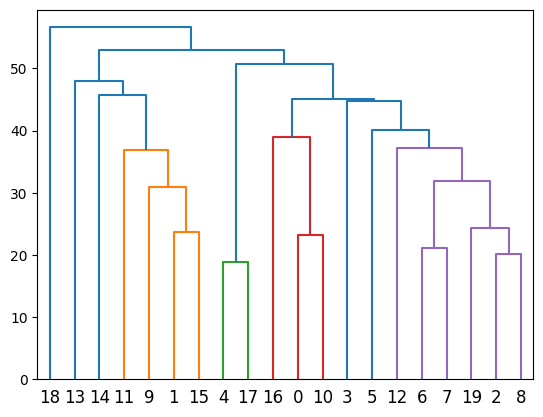

In [ ]:
_ = dendrogram(Z)

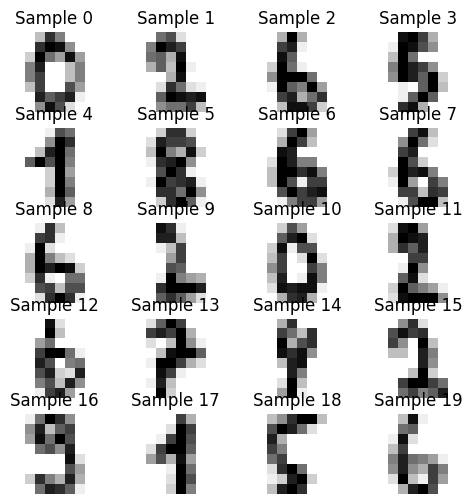

In [ ]:
_, axes = plt.subplots(nrows=5, ncols=4, figsize=(6, 6))
for i, (ax, image) in enumerate(zip(axes.flatten(), digits)):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Sample {i}')

**Выводы:**


Если посмотреть на номера семплов и сопоставить их с картинкой, то правда получается, что объединяются в кластеры идентичные (или почти идентичные) цифры.

Так получается, что сложно четко выделить классы, но в целом, можно разбить наблюдения на +- 4 класса:
1. Овалы (семплы 0, 10, 16 и тд)
2. Кривенькте палки с чертчкой (семплы 1, 15, 9 11 и др)
3. Что то близкое к шестеркам (семплы 2, 8, 6, 7 и тд)
4. Отдельно выделился 18 семпл, там у нас пятерка, но я бы честно отнесла его к 3ми классу

Так что вроде бы кластеризация хороша, но не идеальна, можно подумать над реализацией разного рода измерения расстояний, возможно станет лучше